#  N-type thermocouple sensor accuracy calculation using Monte Carlo

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import time
from scipy.stats import norm, skew, normaltest

# Abstract
In this study the accuracy of thermocouple sensor is calculated using Monte Carlo algorithm.

# Introduction
Thermocouples are widely used for temperature sensors in the automotive industry for measurement of exhaust gas temperature. One of the most suitable thermocouple type is type N. Typical sensor is made from probe, flexible cable and electronics. A pair of solid leads is inserted in the probe. The signal is conducted to the electronics by the flexible wires, which are again type N thermocouple. This is needed to create cold junction close to the electronics, where RTD sensor is used to measure the cold junction temperature. Type N thermocouples are delivered according standards, defining their accuracy. The sensor accuracy depends on the accuracy of the leads pair, flexible wire pair and the electronics. The following project demonstrates how the accuracy of leads and wires are combined to calculate sensor accuracy using Monte Carlo algorithm. There are several complications that make simpler methods not applicable: 
- the temperature of the weld between leads and wires is not known
- the generated voltage is not linearly proportional to the temperature difference
- leads and wires are made from different batches and their electromotive force is not equal
![title](DTC.png)

In this study both leads and wires are delivered according ASTM E230 Type N thermo couple with accuracy class 1. Below a sensor break down is shown.
![title](sensor_breakdown.png)

# Goal definition
The goal of this study is to calculate the accuracy of a thermocouple sensor made from two TC pairs type N. 

Inputs:
1. TC pairs type N class 1 according ASTM E230
2. Assume the supplier of TC pairs is capable Ppk=1 (99.7% confidence, 3σ in the specification limits)
3. Sensor tip temperatures of interest from 0 to 1100°C
4. Assume welds between both TC pairs are at the same temperature. This temperature is in the range between 0°C and 260°C. It could be also assumed the weld temperature is equal to 0.3 multiplied by the temperature of the tip.
5. The temperature of the cold junction can be in the range of 0°C to 150°C
6. Assume electronics adds no error. (it is outside the scope of this study)

Outputs:
1. 4 temperature accuracy curves based on minimum and maximum temperatures of the cold junction and welds.
2. All accuracy values should be delivered with 3σ confidence level
3. Envelop accuracy to be used for sensor specification

# ASTM E230 review and implementation
This section implements the required functions and tables from ASTM E230.

In [2]:
def leads_accuracy(t_hot):
    """
    Thot is the temperature of the hot junction in °C
    The output is the absolute maximum acceptable deviation in °C
    """
    if t_hot >= 0:
        return np.maximum(1.1, 0.004 * t_hot)
    else:
        raise ValueError("ASTM E230 Type N class 1 does not cover sub zero temperatures")

def wires_accuracy(t_hot):
    """
    Thot is the temperature of the hot junction in °C
    The output is the absolute maximum acceptable deviation in °C
    """
    if t_hot >= 0:
        return np.maximum(1.1, 0.004 * t_hot)
    else:
        raise ValueError("ASTM E230 Type N class 1 does not cover sub zero temperatures")


Let's plot the limits.

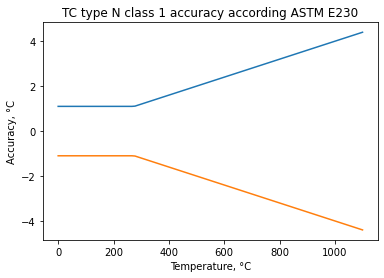

In [3]:
x_values = np.linspace(0, 1100, 100)
y_values = np.vectorize(leads_accuracy)(x_values)
plt.plot(x_values, y_values)
plt.plot(x_values, -y_values)

plt.title("TC type N class 1 accuracy according ASTM E230")
plt.xlabel("Temperature, °C")
plt.ylabel("Accuracy, °C")
plt.show()

It is important to note that any curve within the limits defined above is acceptable. It is possible some TC batch to show curve starting from the lower specification limit (LSL) goes up to the upper specification limit (USL) and then goes down to LSL.

In order to make the transformations from the generated voltage to temperature and reverse, we need to define functions for the nominal transformation. These functions are polynomials, also defined in ASTM E230. The polynomial coefficients depends on the voltage of interest, so several sets of polynomials are defined.

In [4]:
def get_temperature_from_emf(emf):
    """
    acc ASTM E230, table 46 TYPE N Thermocouple
    E is the thermocouple emf in mV
    returns in °C
    """
    coeff1 = [0, 38.436847, 1.1010485, 5.2229312, 7.2060525, 5.8488586, 2.7754916, 0.77075166, 0.11582665, 0.0073138868]
    coeff2 = [0, 38.6896, -1.08267, 0.0470205, -2.12169e-06, -0.000117272, 5.3928e-06, -7.98156e-08]
    coeff3 = [19.72485, 33.00943, -0.3915159, 0.009855391, -0.0001274371, 7.767022e-07]
    if 0 <= emf < 20.613: # starting with the most used temperature range
        return np.polynomial.polynomial.polyval(emf, coeff2)
    elif 20.613 <= emf <= 47.513:
        return np.polynomial.polynomial.polyval(emf, coeff3)
    elif -3.99 <= emf < 0:
        return np.polynomial.polynomial.polyval(emf, coeff1)
    else:
        raise ValueError(f"EMF value of {emf}mV is outside specified range!")
    
    
def get_emf_from_temperature(t):
    """
    acc ASTM E230, 
    t is the thermocouple hot junction temperature in °C
    returns in mv
    """
    coeff1 = [0, 0.026159105962, 1.0957484228e-05, -9.3841111554e-08, -4.6412039759e-11, -2.633357716e-12, -2.2653438003e-14, -7.608930791e-17, -9.3419667835e-20]
    coeff2 = [0, 0.025929394601, 1.571014188e-05, 4.3825627237e-08, -2.5261169794e-10, 6.4311819339e-13, -1.0063471519e-15, 9.9745338992e-19, -6.0863245607e-22, 2.0849229339e-25, -3.0682196151e-29]
    if 0 <= t <= 1300:  # starting with the most used temperature range
        return np.polynomial.polynomial.polyval(t, coeff2)
    elif -270 <= t < 0:
        return np.polynomial.polynomial.polyval(t, coeff1)
    else:
        raise ValueError("Temperature outside specified range -270 to 1300°C")
    
    
def get_emf_derivative(t):
    """
    acc ASTM E230, 
    t is the thermocouple hot junction temperature in °C
    returns in mv
    """
    coeff1 = [0, 0.026159105962, 1.0957484228e-05, -9.3841111554e-08, -4.6412039759e-11, -2.633357716e-12, -2.2653438003e-14, -7.608930791e-17, -9.3419667835e-20]
    coeff2 = [0, 0.025929394601, 1.571014188e-05, 4.3825627237e-08, -2.5261169794e-10, 6.4311819339e-13, -1.0063471519e-15, 9.9745338992e-19, -6.0863245607e-22, 2.0849229339e-25, -3.0682196151e-29]
    if 0 <= t <= 1300:
        coeff_of_dervived = np.polynomial.polynomial.polyder(coeff2)
        return np.polynomial.polynomial.polyval(t, coeff_of_dervived)
    elif -270 <= t < 0:
        coeff_of_dervived = np.polynomial.polynomial.polyder(coeff1)
        return np.polynomial.polynomial.polyval(t, coeff_of_dervived)
    else:
        raise ValueError("Temperature outside specified range -270 to 1300°C")

Keep in mind the forward and backward function are approximations. Small differences are expected. Let's plot the relation between electromotive force (EMF) and temperature:

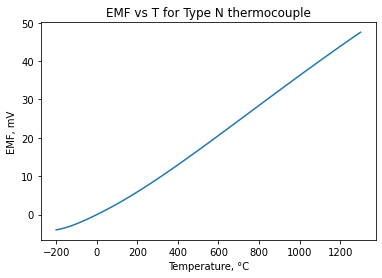

In [5]:
x_values = np.linspace(-200, 1300, 100)
y_values = np.vectorize(get_emf_from_temperature)(x_values)
plt.plot(x_values, y_values)
plt.title("EMF vs T for Type N thermocouple")
plt.xlabel("Temperature, °C")
plt.ylabel("EMF, mV")
plt.show()

The function is close to linear, but some curvature is easily seen.
Now let's see the first derivative. This gives indication for the sensitivity of the TC.

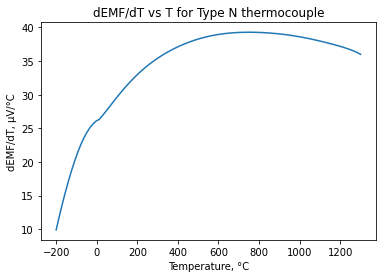

In [6]:
x_values = np.linspace(-200, 1300, 100)
y_values = np.vectorize(get_emf_derivative)(x_values) * 1000
plt.plot(x_values, y_values)
plt.title("dEMF/dT vs T for Type N thermocouple")
plt.xlabel("Temperature, °C")
plt.ylabel("dEMF/dT, µV/°C")
plt.show()

For research purposes linear functions will be defined. The average slope is approximated from the first derivative.

In [7]:
def get_temperature_from_emf_linear(emf):
    return emf / 0.035

def get_emf_from_temperature_linear(t):
    return t * 0.035

# How does the sensor work?
![title](TC_schema.png)
Steps to calculate the hot junction temperature:
1. ASIC measures the cold junction temperature (T2)
2. The ASIC measures the voltage across the cold junction (V2)
3. Calculates the expected V1 = f(T2)
4. Calculates V3 = V1 + V2
5. Calculates the hot junction temperature T3 = f(V3)

# Accuracy calculations
If the sensor was made from only one pair of leads, the accuracy is straightforward - defined in ASTM E230. However, the sensor consists of two pairs produced from different material batches. The actual EMF characteristic may (will) differ for the leads and wires. It will be assumed the accuracy of delivered batches follows normal distribution with 3σ confidence (Ppk=1). Such assumption is normal practice in the industry. Higher Ppk values could be requested, but are deemed as not feasible due to technology limitations and expected price increase.
Keep in mind that both ends of one TC pair add value to the accuracy. 
It will be assumed the temperature of the weld between the leads and wires is at the minimum of 0.3*T and 260°C. This assumption is realistic, the upper limit of 260°C is defined by the resistance of the rubber seal of the probe. Also the accuracy limits are the same (±1.1°C) up to 275°C.
The temperature of the cold junction will be assumed 25°C. This value is below 275°C and the added accuracy value will be ±1.1°C.


In [8]:
def generate_monte_carlo(t, t_weld = None, t_cold_junction = None, number_of_combos = None, model='E230'):
    """
    The function generates an array of accuracy deviations.
    """
#     start_time = time.time()
    if t_weld is None:
        t_weld = np.minimum(0.3 * t, 260)
    if t_cold_junction is None:
        t_cold_junction = 20
    if number_of_combos is None:
        number_of_combos = 10000
    if model=='E230':
        emf_from_temperature = get_emf_from_temperature
        temperature_from_emf = get_temperature_from_emf
    elif model=='linear':
        emf_from_temperature = get_emf_from_temperature_linear
        temperature_from_emf = get_temperature_from_emf_linear
    else:
        raise  ValueError(f"{model} is not implemented model")
        
    rng_1 = np.random.Generator(np.random.Philox(seed=9729)) # Philox(high quality) or SFC64 (fast); time diffrence not dramatic
    rng_2 = np.random.Generator(np.random.Philox(seed=4593))
    rng_3 = np.random.Generator(np.random.Philox(seed=7925))
    rng_4 = np.random.Generator(np.random.Philox(seed=1687))
    
    leads_std_accuracy_hot = leads_accuracy(t) / 3
    leads_std_accuracy_cold = leads_accuracy(t_weld) / 3
    wires_std_accuracy_hot = wires_accuracy(t_weld) / 3
    wires_std_accuracy_cold = wires_accuracy(t_cold_junction) / 3
    
    emf_from_temperature_v = np.vectorize(emf_from_temperature)
    temperature_from_emf_v = np.vectorize(temperature_from_emf)
    
#     print(f"It took {time.time()-start_time}s to adjust")
    v_leads = emf_from_temperature_v(rng_1.normal(loc=t, scale=leads_std_accuracy_hot, size = number_of_combos)) - \
              emf_from_temperature_v(rng_2.normal(loc=t_weld, scale=leads_std_accuracy_cold, size = number_of_combos))
#     print(f"It took {time.time()-start_time}s to calc v_lead")    
    v_wires = emf_from_temperature_v(rng_3.normal(loc=t_weld, scale=wires_std_accuracy_hot, size = number_of_combos)) - \
              emf_from_temperature_v(rng_4.normal(loc=t_cold_junction, scale=wires_std_accuracy_cold, size = number_of_combos))
#     print(f"It took {time.time()-start_time}s to calc v_lead and v_wires")
    v_cold_junction = v_leads + v_wires
    v_cold_junction_ref = emf_from_temperature(t_cold_junction) 
    t_calculated = temperature_from_emf_v(v_cold_junction + v_cold_junction_ref)
    deviations = t_calculated - t
    
#     print(f"It took {time.time()-start_time}s to calculate")
    return deviations

# Testing the generator

Test for normality of the output

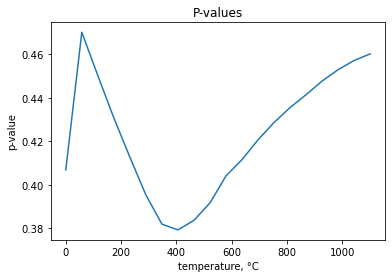

In [9]:
x = np.linspace(0, 1100, 20)
p_values = []
for t in x:
    pool = generate_monte_carlo(t)
    k2, p = normaltest(pool)
    p_values.append(p)
plt.title("P-values")
plt.xlabel("temperature, °C")
plt.ylabel("p-value")
plt.plot(x, p_values)
plt.show()

test comment: <br>
Null hypothesis: the pool comes from a normal distribution. The p-value is above 0.05 so the null hypothesis cannot be rejected; there is chance the distribution to be normal. <br>
This is not a strong test. It is possible some combinations of inputs to reject the null hypothesis. Also, if we use lower number of combinations we might get lower p-values, and eventually reject the null hypothesis. <br>
The inputs for the generator follow normal distribution. If the model is linear, the output of the model should also follow normal distribution. In this case the model is close to linear. If the code is reused for other types of thermocouples, with higher non-linearity, the output might not be normal.

It took 0.5964s to generate the monte carlo cases.
p-value = 0.45419783268559055
The expected deviation at 1000°C is within 0.00±4.294°C with 3σ confidence.
Calculating the interval with 99.7% confidence (3σ)
Median: -0.004°C; percentline_lower: -4.142°C; percentline_upper: 4.225°C
Skewness: 0.0288


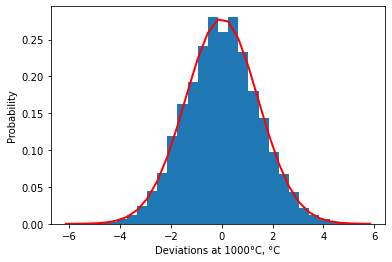

In [10]:
start_time = time.time()
deviations = generate_monte_carlo(1000)
print(f"It took {time.time()-start_time:.4f}s to generate the monte carlo cases.")

k2, p = normaltest(deviations)
print(f"p-value = {p}")

sigma = np.std(deviations)
miu = np.mean(deviations)
median = np.median(deviations)
skewness = skew(deviations)
percentline_lower = np.percentile(deviations, 100*norm.cdf(-3, loc=0, scale=1))
percentline_upper = np.percentile(deviations, 100*norm.cdf(3, loc=0, scale=1))

print(f"The expected deviation at 1000°C is within {miu:.2f}±{3 * sigma:.3f}°C with 3σ confidence.")
print("Calculating the interval with 99.7% confidence (3σ)")
print(f"Median: {median:.3f}°C; percentline_lower: {percentline_lower:.3f}°C; percentline_upper: {percentline_upper:.3f}°C")
print(f"Skewness: {skewness:.4f}")

count, bins, ignored = plt.hist(deviations, 30, density=True)
plt.plot(bins, 1/(sigma * np.sqrt(2 * np.pi)) * np.exp( - (bins - miu)**2 / (2 * sigma**2) ), linewidth=2, color='r')
plt.xlabel("Deviations at 1000°C, °C")
plt.ylabel("Probability")
plt.show()

The mean and median are very close to 0°C. The skewness is positive, the lower limit is closer to the median than the upper limit. Let's plot the skewness below.

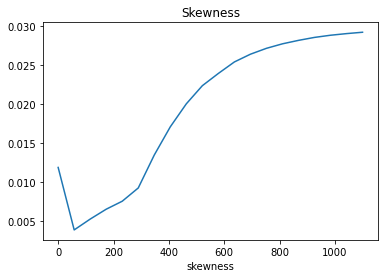

In [11]:
x = np.linspace(0, 1100, 20)
skewnesses = []
for t in x:
    pool = generate_monte_carlo(t)
    s = skew(pool)
    skewnesses.append(s)
plt.title("Skewness")
plt.xlabel("temperature, °C")
plt.xlabel("skewness")
plt.plot(x, skewnesses)
plt.show()

The skewness is small and always positive for all reviewed cases. The skewness might be caused by the small differences between the forward and backward polynomial transformations.

### Obtaining the accuracy
The accuracy could be calculated from 3 times the standard deviation or by finding the percentile corresponding to the desired confidence of 97.3%. The code below compares both approaches.

In [12]:
x = np.linspace(0, 1000, 5)
for t in x:
    pool = generate_monte_carlo(t, number_of_combos=200_000)
    mean = np.mean(pool)
    std = np.std(pool)
    median = np.median(pool)
    percentline_lower = np.percentile(pool, 100*norm.cdf(-3, loc=0, scale=1))
    percentline_upper = np.percentile(pool, 100*norm.cdf(3, loc=0, scale=1))
    print(f"Analysis at {t}°C")
    print(f"By std devia.: LSL={mean - 3 * std:.3f}°C mean={mean:.3f}°C USL={mean + 3 * std:.3f}°C")
    print(f"By percentile: LSL={percentline_lower:.3f}°C mean={median:.3f}°C USL={percentline_upper:.3f}°C")

Analysis at 0.0°C
By std devia.: LSL=-2.215°C mean=0.001°C USL=2.218°C
By percentile: LSL=-2.212°C mean=-0.001°C USL=2.212°C
Analysis at 250.0°C
By std devia.: LSL=-1.902°C mean=0.000°C USL=1.902°C
By percentile: LSL=-1.899°C mean=0.000°C USL=1.904°C
Analysis at 500.0°C
By std devia.: LSL=-2.499°C mean=-0.007°C USL=2.485°C
By percentile: LSL=-2.485°C mean=-0.007°C USL=2.483°C
Analysis at 750.0°C
By std devia.: LSL=-3.362°C mean=0.003°C USL=3.369°C
By percentile: LSL=-3.343°C mean=0.003°C USL=3.372°C
Analysis at 1000.0°C
By std devia.: LSL=-4.293°C mean=0.010°C USL=4.313°C
By percentile: LSL=-4.280°C mean=0.009°C USL=4.318°C


Both approaches produce very similar results, with difference up to 0.02°C, at relatively high number of combinations. In the next chapter it will be demonstrated that the approach with standard deviation needs less combinations to produce repeatable results.

### How many combinations do we need?
More combinations will give more accurate calculations, but infinity is not an option. We first have to set a target for calculation accuracy. Stepping on AIAG standards for gage repeatability and reproducibility (GR&R), the measurement system should have variation at most 10% of the specification tolerance. The sensor specification is not known so far, so we will take the specification for a single TC. This approach is on the safe side. The confidence level of 3σ (or 99.7%) is accepted for the required number of combinations.

Data pool for t = 100°C created for 18.96s
Mean reference temperature at 100°C is -0.0159°C
Median reference temperature at 100°C is -0.0165°C
Lower limit at 0.13% -2.0628°C
Upper limit at 99.87% 2.0352°C
Data pool for t = 275°C created for 15.18s
Mean reference temperature at 275°C is -0.0066°C
Median reference temperature at 275°C is -0.0070°C
Lower limit at 0.13% -1.8932°C
Upper limit at 99.87% 1.8911°C
Data pool for t = 640°C created for 13.80s
Mean reference temperature at 640°C is -0.0005°C
Median reference temperature at 640°C is -0.0002°C
Lower limit at 0.13% -2.9493°C
Upper limit at 99.87% 2.9691°C
Data pool for t = 1000°C created for 13.54s
Mean reference temperature at 1000°C is 0.0076°C
Median reference temperature at 1000°C is 0.0067°C
Lower limit at 0.13% -4.2845°C
Upper limit at 99.87% 4.3037°C


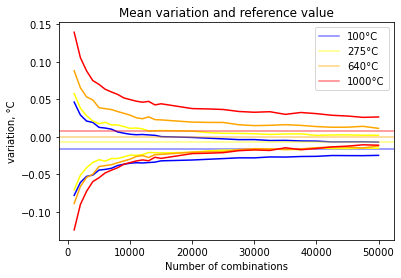

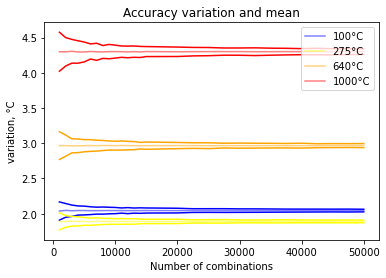

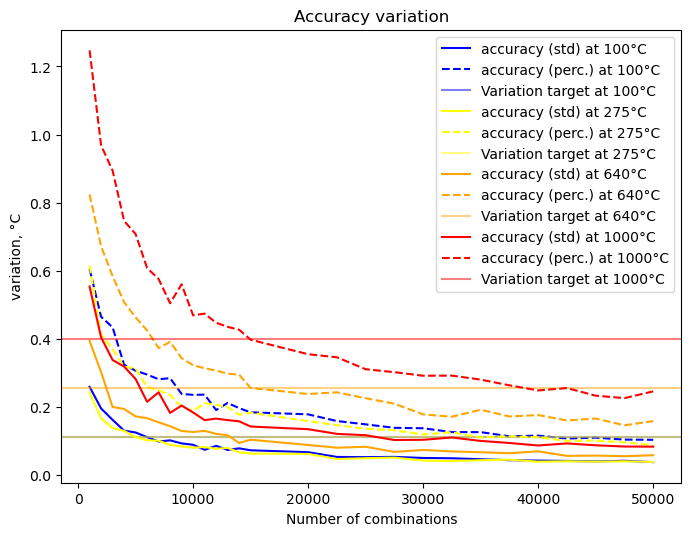

Total run time 97.80s


In [13]:
def measurment_accuracy_mc():
    t_start = time.time()
    temperatures = [100, 275, 640, 1000] # temperatures for which the stability of the implementation will be checked
    cmap = ["blue", "yellow", "orange", "red"]
    plot_mean_variation = dict()
    plot_accuracy_variation = dict()
    plot_accuracy_mean = dict()
    plot_mean_reference = dict()
    plot_interval_99_7_variation = dict()
    
    x = list(range(1000, 15001, 1000))
    x.extend(list(range(20000, 50001, 2500))) #number of combinations to analyze
    
    for t in temperatures:
        plot_mean_variation[t] = []
        plot_accuracy_variation[t] = []
        plot_accuracy_mean[t] = []
        plot_interval_99_7_variation[t] = []
              
        t_start_data_pool = time.time()
        # it is imperative the data pool to be larger than the number of values we pick
        # if the data pool is 150_000 values and we pick 120_000 several times we will get low variation that is false
        data_pool = generate_monte_carlo(t, number_of_combos = 5 * np.max(x)) 
        t_end_data_pool = time.time()
        print(f"Data pool for t = {t}°C created for {(t_end_data_pool-t_start_data_pool):.2f}s")
        
        plot_mean_reference[t] = np.mean(data_pool)
        print(f"Mean reference temperature at {t}°C is {plot_mean_reference[t]:.4f}°C")
        print(f"Median reference temperature at {t}°C is {np.median(data_pool):.4f}°C")
        percentline_lower = np.percentile(data_pool, 100*norm.cdf(-3, loc=0, scale=1))
        percentline_upper = np.percentile(data_pool, 100*norm.cdf(3, loc=0, scale=1))
        print(f"Lower limit at {100*norm.cdf(-3, loc=0, scale=1):.2f}% {percentline_lower:.4f}°C")
        print(f"Upper limit at {100*norm.cdf(3, loc=0, scale=1):.2f}% {percentline_upper:.4f}°C")      
        
        for n_combos in x:
            run_means = []
            run_accuracies = []  
            run_intervals = []
            for run in range(0, 200):
                data_sub_set = np.random.choice(data_pool, size = n_combos) 
                mean = np.mean(data_sub_set)
                std = np.std(data_sub_set)
                accuracy = 3 * std
                interval_99_7 = 0.5*(np.percentile(data_sub_set, 100*norm.cdf(3, loc=0, scale=1)) - \
                                     np.percentile(data_sub_set, 100*norm.cdf(-3, loc=0, scale=1)))
                run_means.append(mean)
                run_accuracies.append(accuracy)
                run_intervals.append(interval_99_7)
            # calcualting the variations of the mean and the accuracy
            # it is expected the true mean to be 0 - see the discussion later
            mean_variation= 6 * np.std(run_means)
            accuracy_variation = 6 * np.std(run_accuracies)
            accuracy_mean = np.mean(run_accuracies)
            # do not make mean of means; this efect is the same as looking at more cobinations
            interval_variation = 6 * np.std(run_intervals)

            plot_mean_variation[t].append(mean_variation)
            plot_accuracy_variation[t].append(accuracy_variation)
            plot_accuracy_mean[t].append(accuracy_mean) 
            plot_interval_99_7_variation[t].append(interval_variation)
            
        plot_mean_variation[t] = np.array(plot_mean_variation[t])
        plot_accuracy_variation[t] = np.array(plot_accuracy_variation[t])
        plot_accuracy_mean[t] = np.array(plot_accuracy_mean[t])
        plot_interval_99_7_variation[t] = np.array(plot_interval_99_7_variation[t])
        
    plt.title("Mean variation and reference value")
    plt.xlabel("Number of combinations")
    plt.ylabel("variation, °C")
    for i, t in enumerate(plot_mean_variation):
        mean_ref = plot_mean_reference[t]
#         print(f"Mean reference temperature at {t}°C is {mean_ref:.4f}°C")        
        plt.axhline(mean_ref, color = cmap[i], label=f"{t}°C", alpha=0.5)
        plt.plot(x, mean_ref + 0.5*plot_mean_variation[t], color = cmap[i])
        plt.plot(x, mean_ref - 0.5*plot_mean_variation[t], color = cmap[i])
    plt.legend(loc="upper right")
    plt.show()
    
    plt.title("Accuracy variation and mean")
    plt.xlabel("Number of combinations")
    plt.ylabel("variation, °C")
    for i, t in enumerate(plot_accuracy_mean):
        plt.plot(x, plot_accuracy_mean[t], color = cmap[i], label=f"{t}°C", alpha=0.5)
        plt.plot(x, plot_accuracy_mean[t] + 0.5*plot_accuracy_variation[t], color = cmap[i])
        plt.plot(x, plot_accuracy_mean[t] - 0.5*plot_accuracy_variation[t], color = cmap[i])
    plt.legend(loc="upper right")
    plt.show()
    
    plt.figure(figsize=(8,6), dpi=100)
    plt.title("Accuracy variation")
    plt.xlabel("Number of combinations")
    plt.ylabel("variation, °C")
    for i, t in enumerate(plot_accuracy_mean):        
        plt.plot(x, plot_accuracy_variation[t], color = cmap[i], label=f"accuracy (std) at {t}°C")
        plt.plot(x, plot_interval_99_7_variation[t], "--", color = cmap[i], label=f"accuracy (perc.) at {t}°C")
        plt.axhline(0.1 * leads_accuracy(t), color = cmap[i], alpha=0.5, label=f"Variation target at {t}°C")
    plt.legend() # loc="upper right"
    plt.show()
    print(f"Total run time {(time.time()-t_start):.2f}s")
measurment_accuracy_mc()

The mean value is close to 0, but not exactly 0°C. The polynomial functions defined for the EMF to temperature transitions are approximate. The forward and backward functions do not produce the same result. The code below checks if this is the reason for the non-zero means.

In [14]:
d100 = get_temperature_from_emf(get_emf_from_temperature(100)) - 100
d275 = get_temperature_from_emf(get_emf_from_temperature(275)) - 275 
d640 = get_temperature_from_emf(get_emf_from_temperature(640)) - 640
d1000 = get_temperature_from_emf(get_emf_from_temperature(1000)) - 1000
print(f"The polynomial transoformations at 100°C will produce error of {d100:.4f}°C")
print(f"The polynomial transoformations at 275°C will produce error of {d275:.4f}°C")
print(f"The polynomial transoformations at 640°C will produce error of {d640:.4f}°C")
print(f"The polynomial transoformations at 1000°C will produce error of {d1000:.4f}°C")

The polynomial transoformations at 100°C will produce error of -0.0154°C
The polynomial transoformations at 275°C will produce error of -0.0063°C
The polynomial transoformations at 640°C will produce error of -0.0004°C
The polynomial transoformations at 1000°C will produce error of 0.0074°C


The mean reference values are close to the error from forward and backward transformation. It will be accepted there is no shift in the mean of the specification. The sensor specification will be symmetrical around 0°C.

The data shows 10000 combinations cover the AIAG requirement with enough confidence, when the accuracy is obtained from standard deviation. If we use the percentile approach more combinations will be needed - about 45000. The accuracy from standard deviation and percentile approach tends to the same value once the number of combinations is increased. <br>
For the following calculations the standard deviation approach will be used with 10000 combination. The percentile approach is the correct one, but the error in this case by using standard deviation approach is neglectable. If the code is reused for other types of thermocouples, it it possible the difference to become significant.<br>
It looks like the accuracy variation is approaching a constant value. Maybe numeric error limit has been reached, and more combinations will not decrease the variation to 0. If needed, one should look in other optimization techniques apart from increasing the number of combinations.<br>
Most of the calculation time is spend in generating the data pools.

# Calculating the accuracy
Below the expected accuracy is calculated with 3σ confidence.

In [15]:
def plot_sensor_accuracy(t_min, t_max, model='E230'):
    x = np.linspace(t_min, t_max, 20)
    x = np.sort(np.append(x, [1.1/0.004])) #adding a key point from lead accuracy specificaion
    temperature_cases = {"default": [None, None, "red"], #list of Tweld, Tcold and color on the graph
                         "case 0, 0": [0, 0, "blue"],
                         "case 260, 0": [260, 0, "yellow"],
                         "case 0, 150": [0, 150, "magenta"],                         
                         "case 260, 150": [260, 150, "orange"]}
    accuracy_curves = []
    generate_monte_carlo_v = np.vectorize(generate_monte_carlo)
    plt.figure(figsize=(8,6), dpi=100)
    plt.title("Sensor accuracy using Monte Carlo")
    plt.xlabel("Temperature, °C")
    plt.ylabel("3σ temperature accuracy, °C")
    for key, value in temperature_cases.items():
        accuracy = []
        for t in x:
            data_pool = generate_monte_carlo_v(t, t_weld = value[0], t_cold_junction = value[1], model=model)
            accuracy.append(3 * np.std(data_pool))
        y = np.array(accuracy)
        accuracy_curves.append(y)
        plt.plot(x, y, color = value[2], label=key)
        plt.plot(x, - y, color = value[2])
    plt.legend()
    plt.show()
    envelop = []
    for i in range(len(accuracy_curves[0])):
        envelop.append(max([v[i] for v in accuracy_curves]))
    return x, np.array(envelop)

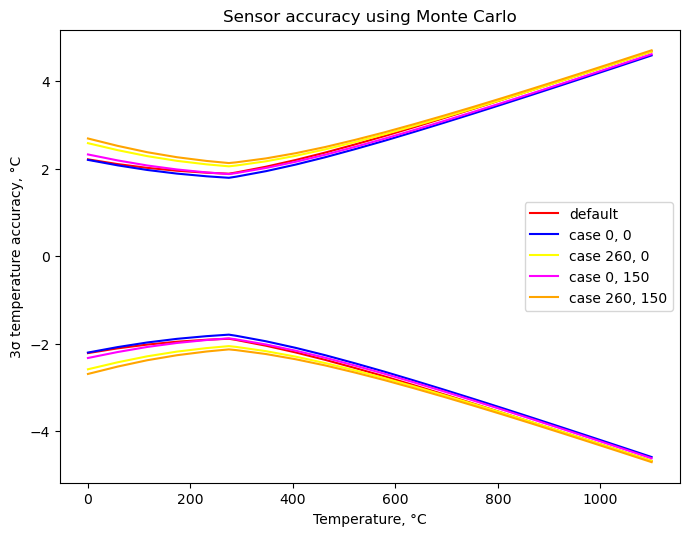

In [16]:
envelop_data = plot_sensor_accuracy(0, 1100)

The graphs look smooth and continues. The accuracy envelope is defined by the case when both the weld and the cold junction are at maximum temperatures. 
In order to define sensor accuracy to be used for customers, a practical definition must be found. Let's try to fit third order polynomial to the envelop. For simplicity only the positive part of the specification will be used. For readability we will round the coefficients.

sensor accuracy specification ±(2.7058910103 + -0.0043114097*T + 1.01125e-05*T^2 + -4.2e-09*T^3)


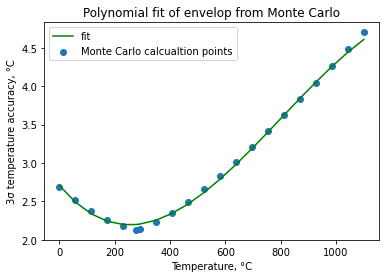

In [17]:
coef = np.polyfit(envelop_data[0], envelop_data[1], 3)
coef = [np.round(c, 10) for c in coef]
print(f"sensor accuracy specification ±({coef[3]} + {coef[2]}*T + {coef[1]}*T^2 + {coef[0]}*T^3)")
poly = np.poly1d(coef)

plot_x = envelop_data[0]
plot_y = poly(plot_x)

plt.title("Polynomial fit of envelop from Monte Carlo")
plt.plot(plot_x, plot_y, c = "green", label="fit")
plt.scatter(envelop_data[0], envelop_data[1], label="Monte Carlo calcualtion points")
plt.xlabel("Temperature, °C")
plt.ylabel("3σ temperature accuracy, °C")
plt.legend()
plt.show()

The third degree polynomial fit gives relatively good match to the Monte Carlo accuracy results. But having so many digits is not user/marketing friendly. Also such definition should be shifted to give 100% capable specification. More user friendly approach is preferred, for example combination of two linear functions.

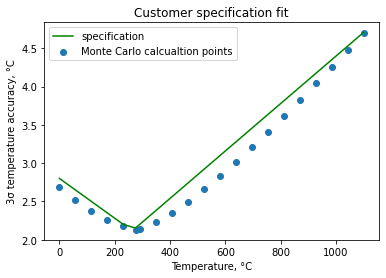

In [18]:
def customer_specification(t):
    if 0 <= t <= 1100:
        return np.maximum(2.8 - 0.0026 * t, 1.3 + 0.0031 * t)
    else:
        raise ValueError("sensor accuracy is specified in the range between 0 and 1100°C")

plot_x = envelop_data[0]
plot_y = np.vectorize(customer_specification)(plot_x)

for i in range(len(plot_x)):
    if plot_y[i] < envelop_data[1][i]:
        print(f"Warning the specification is not on the safe side at {plot_x[i]}°C")
plt.title("Customer specification fit")
plt.plot(plot_x, plot_y, c = "green", label="specification")
plt.scatter(envelop_data[0], envelop_data[1], label="Monte Carlo calcualtion points")
plt.xlabel("Temperature, °C")
plt.ylabel("3σ temperature accuracy, °C")
plt.legend()
plt.show()

The sensor accuracy could be defined as "<b>Absolute temperature deviation in °C is equal to the maximum of 2.8 - 0.0026*t and 1.3 + 0.0031 * t, where t is the temperature of interest in °C. Larger accuracy deviations could be expected in 0.27% of the delivered sensors. Sensor accuracy is guaranteed in the temperature range between 0°C and 1100°C.</b>"

# Discussion
### Comparison between Monte Carlo, SRSS and worst case.
A question is raised what other alternatives to Monte Carlo can be used. The EMF model is close to linear. If we assume it is close enough, we can use the square root of sum of squares root (SRSS). SRSS rule is valid when normal distributions are summed or subtracted.
Other possible approach is to sum the specifications for leads and wires. Such sum will give quite conservative results, but such combination of border cases is very unlikely.
Let's implement and compare the approaches. Please note the ASTM specification defines constant values for accuracy up to 1.1/0.004=275°C. The cold junction and weld temperatures are within the constant 1.1°C accuracy.

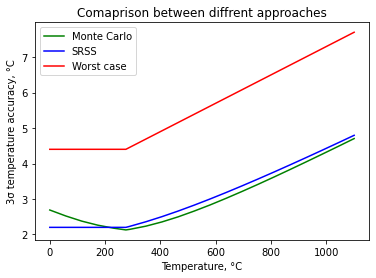

In [19]:
plt.title("Comaprison between diffrent approaches")
plt.xlabel("Temperature, °C")
plt.ylabel("3σ temperature accuracy, °C")

plot_x = envelop_data[0]

#Monte Carlo
plt.plot(plot_x, envelop_data[1], c = "green", label="Monte Carlo")

#SRSS
srss_accuracy = 3 * np.sqrt((np.vectorize(leads_accuracy)(plot_x) / 3)**2 + \
                            (leads_accuracy(0) / 3)**2 + \
                            (wires_accuracy(0) / 3)**2 + \
                            (wires_accuracy(0) / 3)**2)
plt.plot(plot_x, srss_accuracy, c = "blue", label="SRSS")

#Worst case
worst_case_accuracy = 3*((np.vectorize(leads_accuracy)(plot_x) / 3) + \
                        (leads_accuracy(0) / 3) + \
                        (wires_accuracy(0) / 3) + \
                        (wires_accuracy(0) / 3)) 
plt.plot(plot_x, worst_case_accuracy, c = "red", label="Worst case")

plt.legend()
plt.show()

The SRSS results are close to Monte Carlo's. In the next paragraph this observation will be elaborated. SRSS is not on the safe side at low temperatures. As expected, the worst case combination gives much more conservative results.

### What if the EMF(T) model was linear?
It is suspected that the small non-linearity of the EMF(T) model is the root cause for the difference between Monte Carlo and SRSS results. 
At first glance it is a little strange why the accuracy window is larger at 0°C than at 200°C: the accuracy of both leads and wires is constant at ±1.1°C up to 275°C. However, the function EMF(t) is not linear; the slope of the EMF(t) function changes significantly between 0°C and 200°C.
In the implementation below the calculations are repeated if the EMF(T) model was linear only for illustration purposes.

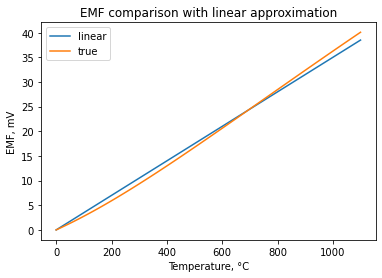

In [20]:
x = np.linspace(0, 1100, 100)
y1 = np.vectorize(get_emf_from_temperature_linear)(x)
y2 = np.vectorize(get_emf_from_temperature)(x)
plt.plot(x, y1, label="linear")
plt.plot(x, y2, label="true")
plt.title("EMF comparison with linear approximation")
plt.xlabel("Temperature, °C")
plt.ylabel("EMF, mV")
plt.legend()
plt.show()

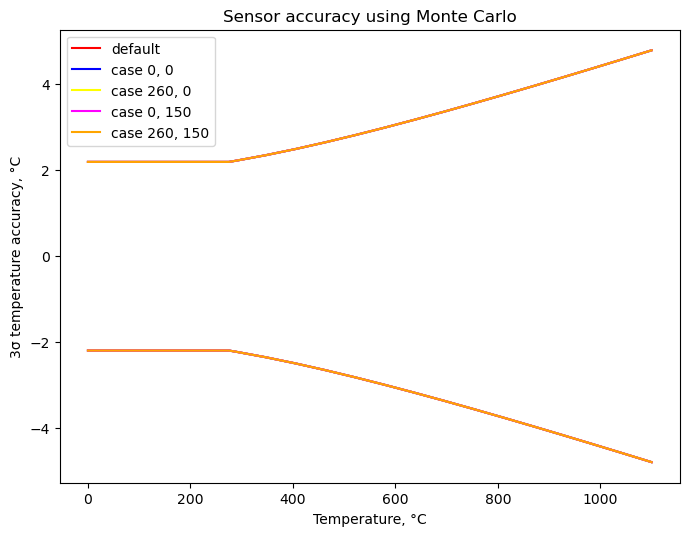

In [21]:
envelop_data_linear = plot_sensor_accuracy(0, 1100, model='linear')

All temperature combinations produce the same result. Note that the function looks bilinear, similar to the leads and wire specification. Let's compare this result with the SRSS approach.

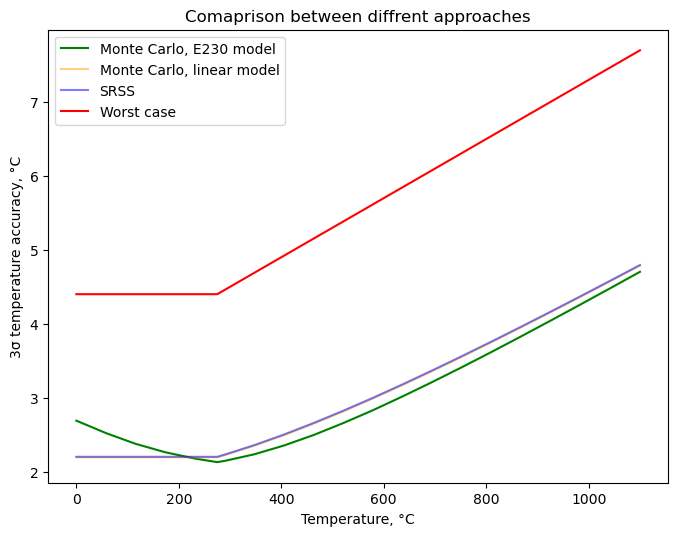

In [22]:
plt.figure(figsize=(8, 6), dpi=100)
plt.title("Comaprison between diffrent approaches")
plt.xlabel("Temperature, °C")
plt.ylabel("3σ temperature accuracy, °C")

plot_x = envelop_data[0]

#Monte Carlo E230 model
plt.plot(plot_x, envelop_data[1], c = "green", label="Monte Carlo, E230 model")

#Monte Carlo linear model
plt.plot(plot_x, envelop_data_linear[1], c = "orange", label="Monte Carlo, linear model", alpha=0.5)

#SRSS
srss_accuracy = 3 * np.sqrt((np.vectorize(leads_accuracy)(plot_x) / 3)**2 + \
                            (leads_accuracy(0) / 3)**2 + \
                            (wires_accuracy(0) / 3)**2 + \
                            (wires_accuracy(0) / 3)**2)
plt.plot(plot_x, srss_accuracy, c = "blue", label="SRSS", alpha=0.5)

#Worst case
worst_case_accuracy = 3 * ((np.vectorize(leads_accuracy)(plot_x) / 3) + \
                          (leads_accuracy(0) / 3) + \
                          (wires_accuracy(0) / 3) + \
                          (wires_accuracy(0) / 3)) 
plt.plot(plot_x, worst_case_accuracy, c = "red", label="Worst case")

plt.legend()
plt.show()

The SRSS method and Monte Carlo with linear EMF model produce the same temperature accuracy. This is very good confirmation the code works as expected.

# Conclusion
The accuracy of a TC sensor can be calculated with the demonstrated Monte Carlo algorithm. SRSS is a quick and easy alternative that can be used for rough estimation only, it is not always on the safe side. Worst case (sum of all accuracies) would indicate much bigger accuracy window, but the probability to have 4 factors at border is very small.<br>
With minor modifications of the code above, one could adjust the calculations to evaluate similar scenarios. <br>
The code above could be used to select the most cost efficient TC class to meet customer requirements.

# References
1. ASTM E230: Standard Specification and Temperature-Electromotive Force (EMF) Tables for Standardized Thermocouples <a href="https://www.astm.org/Standards/E230.htm">link</a>
2. The Type N Thermocouple: The Good, the Bad and the Ugly; E. S. Webster
<a href="https://www.researchgate.net/publication/319875320_The_Type_N_Thermocouple_The_Good_the_Bad_and_the_Ugly">link</a>
3. WHITE PAPER How to Prevent Temperature Measurement Errors When Installing Thermocouple Sensors and Transmitters
<a href="https://docplayer.net/20985926-White-paper-how-to-prevent-temperature-measurement-errors-when-installing-thermocouple-sensors-and-transmitters.html">link</a>
4. Measurement Systems Analysis, AIAG <a href="https://www.aiag.org/store/publications/details?ProductCode=MSA-4">link</a>